In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import os
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from quantnn.qrnn import QRNN

import sys
sys.path.append('../visualize')
from sample_plots import plotRandomSample
sys.path.append('../src')
from load_data import GOESRETRIEVALSDataset, RandomLog, Mask, RandomCrop, Standardize, ToTensor


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cpu


/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
channels = list(range(8,17))
channels.remove(12)
fillvalue = -1
quantiles = np.linspace(0.01, 0.99, 99)

In [3]:
net_name = 'xception'#'xception' #'boxes_one_modified' 
BATCH_SIZE = 64 #64 #256
uselog = True #True
n_epochs = [10, 20, 40]
lrs = [0.01, 0.001, 0.0001]
optimizer = "SGD"
num = 2

In [4]:
filename_extension ='_'+str(n_epochs[num])+'_'+str(lrs[num])+'_'+str(num)
filename = net_name + str(uselog) + str(BATCH_SIZE) + ('_'+str(n_epochs)+'_'+str(lrs)).replace(" ", "")
filename+='_'+optimizer
print(filename+filename_extension)

xceptionTrue64_[10,20,40]_[0.01,0.001,0.0001]_SGD_40_0.0001_2


In [5]:
if (net_name == 'boxes_one'):
	from models.boxes_one import Net
	net = Net(len(quantiles), len(channels))
elif (net_name == 'xception'):
	from quantnn.models.pytorch.xception import XceptionFpn
	net =  XceptionFpn(len(channels), quantiles.size, n_features=128)

In [6]:
channels = list(range(8,17))
channels.remove(12)

quantiles = np.linspace(0.01, 0.99, 99)

fillvalue = -1

path_to_val_data = '../dataset/data/dataset-boxes/validation/npy_files'
path_to_stats = '../dataset/data/dataset-boxes/train/stats.npy'
path_to_results = '../results'

In [7]:
qrnn_model = QRNN.load(os.path.join(path_to_results, filename, 'saved_models', filename+ filename_extension+'.pckl'))

In [8]:
qrnn_model.training_history

<xarray.Dataset>
Dimensions:          (epochs: 70)
Coordinates:
  * epochs           (epochs) int64 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70
Data variables:
    training_loss    (epochs) float64 0.2824 0.2621 0.26 ... 0.2427 0.2423
    validation_loss  (epochs) float64 0.266 0.2628 0.2638 ... 0.2445 0.2455
    MSE              (epochs) float32 14.68 14.67 14.63 ... 14.05 14.01 14.07
    Bias             (epochs) float32 2.25 2.248 2.244 ... 2.155 2.15 2.156
    CRPS             (epochs) float32 0.4961 0.5083 0.5136 ... 0.4845 0.4868

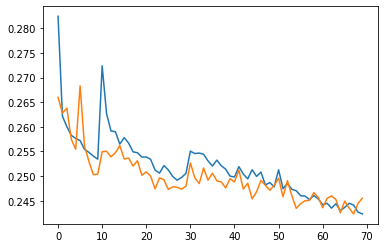

In [9]:
plt.plot(qrnn_model.training_history['training_loss'])
plt.plot(qrnn_model.training_history['validation_loss'])

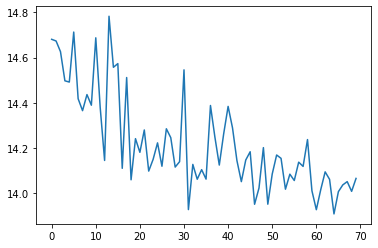

In [10]:
plt.plot(qrnn_model.training_history['MSE'])

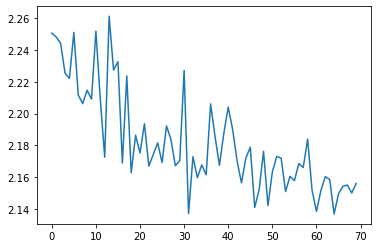

In [11]:
plt.plot(qrnn_model.training_history['Bias'])

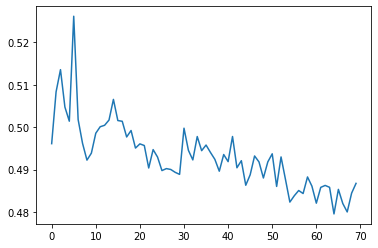

In [12]:
plt.plot(qrnn_model.training_history['CRPS'])

In [13]:
def importData(channels, BATCH_SIZE, path_to_data, path_to_stats, uselog):
    tran = [Mask()]
    if uselog:
        tran.append(RandomLog())
    tran.extend([RandomCrop(128), Standardize(path_to_data, path_to_stats, channels), ToTensor()])
    dataset = GOESRETRIEVALSDataset(
        path_to_data = path_to_data,
        channels = channels, 
        transform = transforms.Compose(tran))
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    return(dataset, dataloader)

validation_dataset, validation_data  = importData(channels, BATCH_SIZE, 
                                                  path_to_val_data, path_to_stats, uselog)


1335

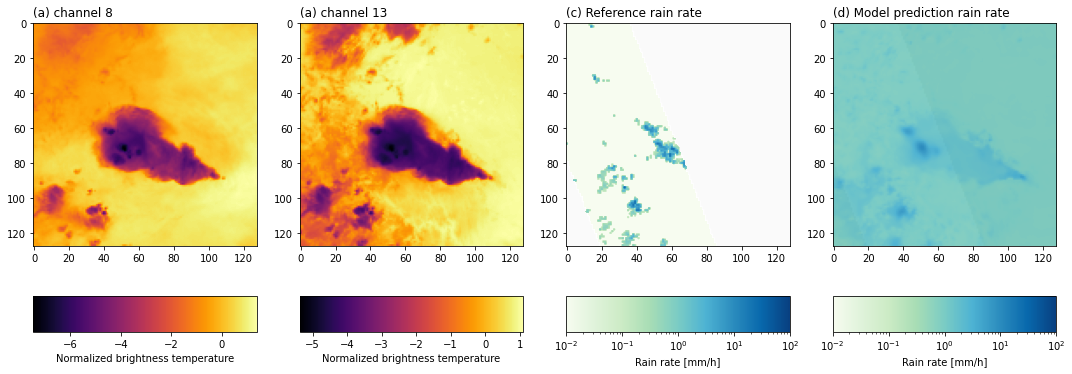

In [24]:
plotRandomSample(validation_dataset,  channels=channels, qrnn=qrnn_model,
                 device=device, cha=[8, 13], uselog=uselog)

In [15]:
'''
def plotPerformance(y_true, y_pred, uselog, save=None):

    bins = np.logspace(-2, 2, 100)
    if uselog:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    freqs, _, _ = np.histogram2d(y_true, y_pred, bins=bins)

    f, ax = plt.subplots(figsize=(8, 9))

    p = ax.pcolormesh(bins, bins, freqs.T)
    ax.set_xlim([1e-2, 1e2])
    ax.set_ylim([1e-2, 1e2])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Reference rain rate [mm / h]")
    ax.set_ylabel("Predicted rain rate [mm / h]")
    ax.plot(bins, bins, c="grey", ls="--")
    f.colorbar(p, ax=ax, orientation="horizontal", label="Surface precipitation [mm / h]")
    ax.set_aspect(1.0)

    plt.tight_layout()
    if not save == None:
        plt.savefig(save)
    plt.show()
'''

'\ndef plotPerformance(y_true, y_pred, uselog, save=None):\n\n    bins = np.logspace(-2, 2, 100)\n    if uselog:\n        y_true = np.exp(y_true)\n        y_pred = np.exp(y_pred)\n    freqs, _, _ = np.histogram2d(y_true, y_pred, bins=bins)\n\n    f, ax = plt.subplots(figsize=(8, 9))\n\n    p = ax.pcolormesh(bins, bins, freqs.T)\n    ax.set_xlim([1e-2, 1e2])\n    ax.set_ylim([1e-2, 1e2])\n    ax.set_xscale("log")\n    ax.set_yscale("log")\n    ax.set_xlabel("Reference rain rate [mm / h]")\n    ax.set_ylabel("Predicted rain rate [mm / h]")\n    ax.plot(bins, bins, c="grey", ls="--")\n    f.colorbar(p, ax=ax, orientation="horizontal", label="Surface precipitation [mm / h]")\n    ax.set_aspect(1.0)\n\n    plt.tight_layout()\n    if not save == None:\n        plt.savefig(save)\n    plt.show()\n'

In [16]:
#Y_train = np.loadtxt(os.path.join(path_to_results, filename, 'preds', filename+filename_extension+'train'+'.txt'))
#plotPerformance(Y_train[:,0], Y_train[:,1], uselog,os.path.join(path_to_results, 'images', filename+ filename_extension+'train'+'.png'))

In [17]:
#Y_val = np.loadtxt(os.path.join(path_to_results, filename, 'preds', filename+filename_extension+'val'+'.txt'))
#plotPerformance(Y_val[:,0], Y_val[:,1], uselog, os.path.join(path_to_results, 'images', filename+ filename_extension+'val'+'.png'))

In [18]:
'''
if uselog:
    plt.hist(np.exp(Y_val[:,0]), bins=100)
    plt.show()
    print(max(np.exp(Y_val[:,0])))
    print(min(np.exp(Y_val[:,0])))
else:
    plt.hist(Y_val[:,0], bins=100)
    plt.show()
'''

'\nif uselog:\n    plt.hist(np.exp(Y_val[:,0]), bins=100)\n    plt.show()\n    print(max(np.exp(Y_val[:,0])))\n    print(min(np.exp(Y_val[:,0])))\nelse:\n    plt.hist(Y_val[:,0], bins=100)\n    plt.show()\n'